# Plotting Reflectivity Fits and Profiles

* **Date Created:** 2020-3-3
* **Date Modified:** 2021-4-15
* **Author:** Brian P. Josey
* **Language:** Python 3.8.3

In this notebook, I am creating and ttesting functions that automatically load and plot reflectivity data, fits, and profiles from the output of a Refl1D fit. While the packages does this automatically, I am unhappy with the quality of the images; they are low resolution PNG files, and the size of the data points are so large that they overlap significantly between adjacent points.

**Goals:**
1. (**Completed**)<s>*Select datasets to plot.*</s>
2. (**Completed**)<s>*Load data into pandas dataframes.*</s>
3. (**Completed**)<s>Plot X-ray reflectivity data.</s>
4. Plot unpolarized neutron reflectivity data.
5. (**Completed**)<s>Plot polarized neutron reflectivity data.</s>
6. (**Completed**)<s>Save publication quality PDF images of the above.</s>
7. (**Completed**)<s>Automate the process as a `.py` script that I can run from the terminal.</s>

The general plan is to address each of the three datasets (X-ray, unpolarized, polarized) in independent functions that create the appropriate plots. After, I will create an additional function that will accept the name of the data and a parameter that specifies which of these types of data it is and then call the appropriate plotting function.

## <span style='color:blue'>Goal 1: Select Data</span>

The datasets I selected represent three types of experiments (X-ray, unpolarized neutron, and polarized neutron) each of which have an associated `-refl.dat` file containing the measured and fitted reflectivities and a `-profile.dat` file containing the associated real-space scattering length density (SLD) profile. All data are saved in the `~/data` directory and are in the cleaned versions.

**Datasets**

The X-ray data from my Nafion project were measured using the NCNR x-ray reflectomter and are saved as `xr-refl.dat` and `xr-profile.dat`. For the unpolarized neutron data, I selected fits from my neurotransmitter project and they are saved as `neutron-refl.dat` and `neutron-profile.dat`. For the polarized neutron data, I again selected fits from the Nafion project and they are saved as `polarized-refl.dat` and `polarized-profile.dat`.


**Reflectivity Curves**

The reflectivity data represent the measured reflectivity, $R$, which is the number of counted neutrons (or X-ray intensity) normalized against the the number at [total internal reflection](https://en.wikipedia.org/wiki/Total_internal_reflection) for a given [momentum transfer vector](https://en.wikipedia.org/wiki/Neutron_reflectometry#Technique), $Q_{z}$. I will not give a detailed explanation of the physics behind reflectometry here, for reference I recommend [Cubitt and Frangento](https://www.ill.eu/fileadmin/user_upload/ILL/3_Users/Scientific_groups/Large_Scale_Structures/People/Giovanna_FRAGNETO/CH2-8-3.PDF).

The `-refl.dat` files store the intensity and background data in the header along with column names. They each contain six columns:

1. `Q (1/A)`: the measured $Q_{z}$ in inverse Ångstroms. This column is typically the plot's $x$-axis.
2. `dQ (1/A)`: the uncertainty in $Q_{z}$. Often refered to as the resolution, this values is often not plotted.
3. `R`: the measured reflectivity normalized so that $R = 1$ corresponds to total internal reflection, typically plotted on the $y$-axis as dots.
4. `dR`: the uncertainty in $R$ and is always included in the plots.
5. `theory`: the best-fit value for $R$ at the given $Q_{z}$ based on the underlying profile as determined by Refl1D, usually plotted on the $y$-axis as a line.
6. `fresnel`: the theoretical Fresnel reflectivity, which is useful for identifying fringes.

Note that the polarized data have two reflectivity curves, one ending in `.datA` and the other in `.datD`. These correspond to the two polarization states, $(-,-)$ and $(+,+)$, that are measured in all polarized experiments—essentially creating two curves for one experiment for contrast matching.

**Profile Curves**

While the reflectivity curves represent the measured data, the profile curves are the fitted [scattering length density](https://www.ncnr.nist.gov/resources/activation/) (SLD) profiles generated by Refl1D. The `-profile.dat` files contain a header with the column names, and all files contain at least three columns:

* `z (A)`: the distance above the substrate in Ångstrom, typically plotted along the $x$-axis.
* `rho (1e—6/A2)`: the real SLD in $10^{-6}$ $Å^{-2}$, typically plotted along the $y$-axis.
* `rho (1e-6/A2)`: the imaginary SLD in the same units and usually not plotted.

Additionally, the neutron reflectometry data includes two more columns:

* `rhoM (1e-6/A2)`: the magnetic SLD in the same units, usually only plotted in polarized experiments.
* `theta (degrees)`: the angle between the incident beam of neutrons and the applied magnetic field. By convention, this is defined as 270$^{\circ}$ for magnetic layers and 0$^{\circ}$ elsewhere.

In [1]:
# Essential libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## <span style='color:blue'>Goal 2: Load Data</span>

It is clear from inspecting the `.dat` files that the data is delimetered by whitespace that varies in length on each row. Presenting the data this way makes it easy for a human to read it, but if I want to use the `pd.read_csv()` method to load the data into a dataframe, I need to set teh parameter `delim_whitespace = True`. This has an odd effect on the header where the column names do not match the data columns; whitespace between the column name and units create additional columns of `NaN`s that need to be discounted. To bypass this issue, I

1. Manually inspected each `.dat` file to determine what column names actually match with the data.
2. Loaded the data into a dataframe by ignoring the columns of `NaN`s.
3. Renamed the column names with the appropriate label.

Each cell corresponds to one of the three datasets.

In [2]:
# X-ray reflectivity
# sld profile
xr_profile = pd.read_csv('data/xr-profile.dat', delim_whitespace=True,
                        usecols = ['#', 'z', '(A)'])
xr_profile.columns = ['z','rho','irho']

# reflectivity
xr_refl = pd.read_csv('data/xr-refl.dat', delim_whitespace=True, 
                      usecols=['#', 'Q', '(1/A)','dQ', '(1/A).1','R'])
xr_refl.columns =['Q', 'dQ','R','dR','theory','fresnel']

In [3]:
# Polarized neutrons
# sld profile
pol_profile = pd.read_csv('data/polarized-profile.dat', delim_whitespace=True,
                          usecols=['#','z','(A)','rho','(1e-6/A2)'])
pol_profile.columns = ['z','rho','irho','rhoM','theta']

# (+,+) reflectivity
pol_refl_A = pd.read_csv('data/polarized-refl.datA', delim_whitespace=True,
                        usecols=['#', 'Q', '(1/A)','dQ', '(1/A).1','R'])
pol_refl_A.columns =['Q', 'dQ','R','dR','theory','fresnel']

# (-,-) reflectivity
pol_refl_D = pd.read_csv('data/polarized-refl.datD', delim_whitespace=True,
                        usecols=['#', 'Q', '(1/A)','dQ', '(1/A).1','R'])
pol_refl_D.columns =['Q', 'dQ','R','dR','theory','fresnel']

## <span style='color:blue'>Goal 3: Plot X-ray Data</span>

Now that I have the data, I want to plot it. My general strategy is to use one cell each to create *ad hoc* plots of the profile and reflectivity curves to select a visual style that I like. Then I will use the next two cells to create and test a function that creates identical images.

For the SLD profiles, I want to plot the `rho` and `irho` as a funciton of `z` on the same plot with linear axes. For reflectometry, I need `R`, `dR`, and `theory` all as a function of `Q` with the $y$-axis on a semilog plot.

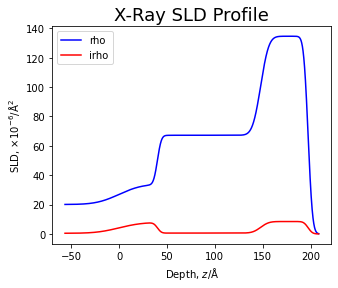

In [4]:
# Plot x-ray sld profile
fig, ax = plt.subplots(figsize = (5,4))  # later (11, 8.5)

ax.plot(xr_profile.z, xr_profile.rho, label='rho', color='blue')
ax.plot(xr_profile.z, xr_profile.irho, label='irho', color='red')
ax.set_xlabel(r'Depth, $z$/Å')
ax.set_ylabel(r'SLD, $\times 10^{-6}$/Å$^{2}$')
ax.set_title("X-Ray SLD Profile", size=18)
ax.legend()

#fig.savefig('output/X-ray SLD.pdf')

[]

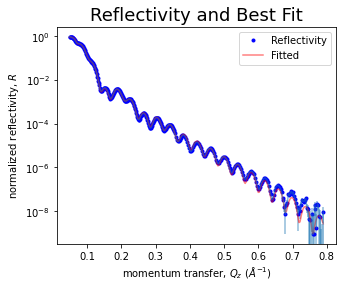

In [5]:
# Plot x-ray reflectometry
fig, ax = plt.subplots(figsize = (5,4)) # later (11, 8.5)

ax.plot(xr_refl.Q, xr_refl.R, '.b', label='Reflectivity', alpha=1)
ax.plot(xr_refl.Q, xr_refl.theory, '-r', label='Fitted', alpha=0.5)
ax.set_xlabel(r'momentum transfer, $Q_{z}\ (Å^{-1})$')
ax.set_ylabel(r'normalized reflectivity, $R$')
ax.set_title(r'Reflectivity and Best Fit', size=18)
ax.legend()

ax.errorbar(xr_refl.Q, xr_refl.R, yerr=xr_refl.dR, fmt='-', alpha =0.5)
ax.semilogy()

#fig.savefig('output/X-ray Fit.pdf')

In [6]:
# Define function that plots the profile

def plot_xr_profile(data='xr-profile', name='X-Ray Substrate'):
    '''
    Function plots the fitted SLD profile fed to it in the arguments.
    
    Arg:
        data (str): File containing the data to be plotted
        name (str): Name of the sample, used for title and saving figure
        
    Output:
        figure: a plot of the data
    '''
    # Load data into a dataframe
    profile = pd.read_csv(f'data/{data}.dat',delim_whitespace=True,
                         usecols=['#', 'z', '(A)'])
    profile.columns = ['z','rho','irho']
    
    # Plot data and show
    
    fig, ax = plt.subplots(figsize = (11, 8.5))
    ax.plot(profile.z, profile.rho, label='rho', color='blue')
    ax.plot(profile.z, profile.irho, label='irho', color='red')
    ax.set_xlabel(r'Depth, $z$/Å')
    ax.set_ylabel(r'SLD, $\times 10^{-6}$/Å$^{2}$')
    ax.set_title(f'{name}', size=18)
    ax.legend()
    fig.savefig(f'output/{name}.pdf')

In [7]:
# Define function that plots reflectivity

def plot_xr_refl(data='xr-refl', name='Reflectivity and Best Fit'):
    '''
    Function plots the measured reflectivity and best fit curve.
    
    Arg:
        data (str): File containing the data to be plotted
        name (str): Name of the sample, used for title and saving figure
        
    Output:
        figure: a plot of the data
    '''
    # Load data into a dataframe
    refl = pd.read_csv(f'data/{data}.dat', delim_whitespace=True,
                      usecols = ['#', 'Q', '(1/A)', 'dQ', '(1/A).1', 'R'])
    refl.columns = ['Q', 'dQ','R','dR','theory','fresnel']
    
    # Generate plot
    fig, ax = plt.subplots(figsize = (11, 8.5))
    
    ax.plot(refl.Q, refl.R, '.b', label='Reflectivity', alpha =1)
    ax.plot(refl.Q, refl.theory, '-r', label='Fitted', alpha = 0.5)
    ax.set_xlabel(r'momentum transfer, $Q_{z}\ (Å^{-1})$')
    ax.set_ylabel(r'normalized reflectivity, $R$')
    ax.set_title(f'{name}', size=18)
    
    ax.errorbar(refl.Q, refl.R, yerr=refl.dR, fmt='-', alpha=0.5)
    ax.semilogy()
    


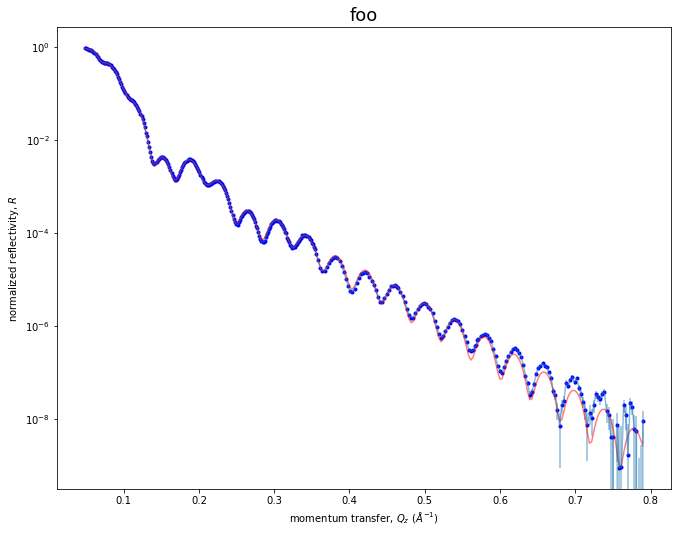

In [8]:
plot_xr_refl(data='xr-refl',name='foo')

## <span style='color:red'>Goal 4: Plot Unpolarized Neutron</span>

Unfortunately, I discovered that I don't have the unpolarized neutron reflectometry data on this computer. I will find it on a back-up harddrive and import it later.

## <span style='color:blue'>Goal 5: Plot Polarized Neutron Data</span>

The code above works well for X-ray and unpolarized neutron data because those experiments give only a single reflectivity curve each and the SLD profile can be plotted with only `rho` (and `irho` for X-ray data). With the addition of magnetic polarization, each experiment has two reflectivity curves: "up-up" (or $(+,+)$) stored in `.datA` files and "down-down" (or $(-,-)$) stored in `.datD` files. So two reflectivity curves must be plotted on each image. Furthermore, the profile requires the inclusion of the magnetic sld, `rhoM`, and the angle between the applied field and neutrons, `theta`.

In contrast to the x-ray data, I am attempting to make these plots by jumping straight into defining a function and troubleshooting as I go.

In [9]:
# Plot magnetic SLD profiles

def plot_pol_profile(data='polarized-profile', name='Polarized Sample'):
    '''
    Function plots the SLD profile of a polarized neutron reflectometry experiment.
    
    Arg:
        data (str): File containing the data to be plotted
        name (str): Name of the sample, used for title and saving figure
        
    Output:
        figure: a plot of the data
    '''
    # Load data into dataframe
    profile=pd.read_csv(f'data/{data}.dat', delim_whitespace=True, #header=2,
                        usecols=["#", "z", "rho", "(1e-6/A2)"])
    profile.columns = ["z", "rho", "rhoM", "theta"]
    
    # Generate plot
    fig, ax = plt.subplots(figsize = (11, 8.5))
    ax.plot(profile.z, profile.rho, label='rho', color='blue')
    ax.plot(profile.z, profile.rhoM, label='rhoM', color='red')
    ax.set_xlabel(r'Depth, $z$/Å')
    ax.set_ylabel(r'SLD, $\times 10^{-6}$/Å$^{2}$')
    ax.set_title(f'{name}', size=18)
    ax.legend()
    fig.savefig(f'output/{name}-profile.pdf')

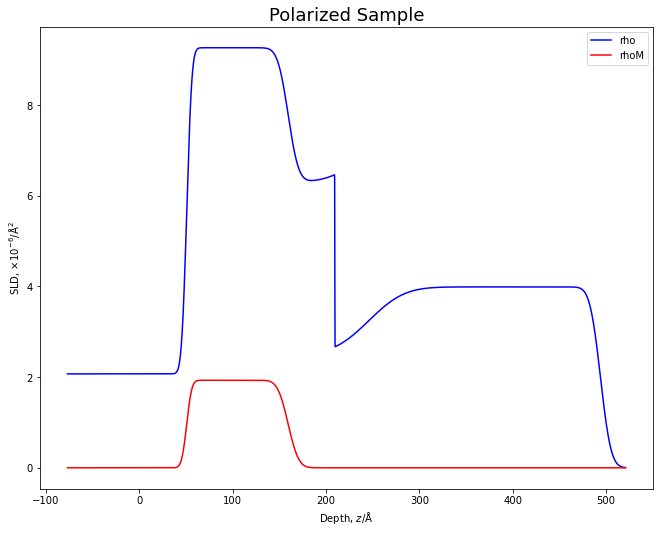

In [10]:
plot_pol_profile()

In [11]:
# Plot magnetic reflectivity

def plot_pol_refl(data='polarized-refl', name='Polarized Sample'):
    '''
    Function plots the SLD profile of a polarized neutron reflectometry experiment.
    
    Arg:
        data (str): File containing the data to be plotted
        name (str): Name of the sample, used for title and saving figure
        
    Output:
        figure: a plot of the data
    '''
    # Load data into dataframe--"up-up"
    refl_A = pd.read_csv(f'data/{data}.datA', delim_whitespace=True,
                        usecols=['#','Q','(1/A)','dQ', '(1/A).1', 'R'])
    refl_A.columns = ['Q','dQ','R','dR','theory','fresnel']
    
    # Load data into dataframe--"down-down"
    refl_D = pd.read_csv(f'data/{data}.datD', delim_whitespace=True,
                        usecols=['#','Q','(1/A)','dQ', '(1/A).1', 'R'])
    refl_D.columns = ['Q','dQ','R','dR','theory','fresnel']

    # Generate plot
    fig, ax = plt.subplots(figsize = (11, 8.5))
    
    ax.plot(refl_A.Q, refl_A.R, '.b', label=r'$(+,+)$', alpha =1)
    ax.errorbar(refl_A.Q, refl_A.R, yerr=refl_A.dR, fmt='-', alpha=0.5)
    ax.plot(refl_D.Q, refl_D.R, '.r', label=r'$(-,-)$', alpha =1)
    ax.errorbar(refl_D.Q, refl_D.R, yerr=refl_D.dR, fmt='-', alpha=0.5)
    
    ax.set_xlabel(r'momentum transfer, $Q_{z}\ (Å^{-1})$')
    ax.set_ylabel(r'normalized reflectivity, $R$')
    ax.set_title(f'{name}', size=18)
    ax.legend()

    ax.semilogy()
    
    fig.savefig(f'output/{name}-refl.pdf')

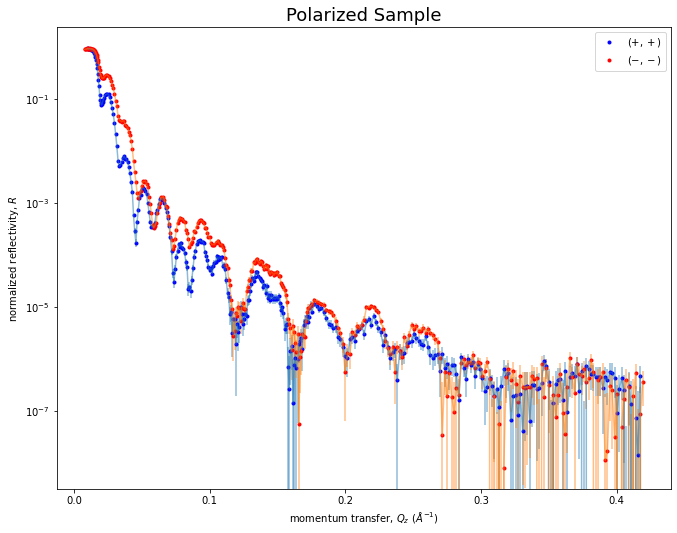

In [12]:
plot_pol_refl()

## <style text='color:blue'>Goal 6: Save Figures as PDFs</span>

This goal was trivial: including the `fig.savefig(f'output/{name}.pdf')` method in each function did this step automatically. I included it as a separate goal to remind myself to save the outputs.

## <span style='color:blue'>Goal 6: Save Figures as PDFs</span>

This goal was trivial: including the `fig.savefig(f'output/{name}-refl.pdf')` line in each function was sufficient. I included it as a separate goal to remind myself to address saving the figures.

## <span style='color:blue'>Goal 7: Export the Functions to a .py File</span>

To complete this goal, I copied the functions from above into a `.py` file I created in Sublime Text. A couple of minor issues came up that I ran into:

1. In the first version of `plot_xr_refl()` I reused some variable names from earlier in this notebook, so when I called the functions through Sublime Text it returned errors. Check your modularity!
2. Remember to include the necessary import statements at the top of the `.py` file, otherwise it won't work.
3. If you remember #2, then the only import statment you need in the Jupyter notebook is something like `from plotting_functions import *`.
4. If you don't explicitly tell a function to show or return a figure, when you run it from the command line it will not work.